In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

2.0.0


In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal((num_examples, num_inputs), stddev=1)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += tf.random.normal(labels.shape,stddev=0.01)


In [3]:
print(features[0], labels[0])

tf.Tensor([ 0.2858297  -0.43183488], shape=(2,), dtype=float32) tf.Tensor(6.2463856, shape=(), dtype=float32)


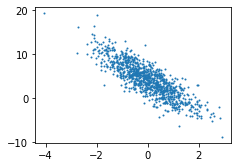

In [4]:
# 设置图像细节 https://www.cnblogs.com/douzujun/p/10327963.html
def set_figsize(figsize=(3.5, 2.5)):
    # 设置图像的最大范围
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
# 绘制散点图 https://blog.csdn.net/TeFuirnever/article/details/88944438
plt.scatter(features[:, 1], labels, 1)

In [5]:
'''在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。'''
def data_iter(batch_size, features, labels):
    # 获取 features 的长度
    num_examples = len(features)
    
    # 将features的坐标进行随机排序 但是以下程序貌似没有用到indices
    indices = list(range(num_examples))
    random.shuffle(indices)

    # 获取小批量数据
    for i in range(0, num_examples, batch_size):
        # min函数 避免数组溢出
        j = indices[i: min(i+batch_size, num_examples)]
        # yield关键字 将data_iter函数变为一个生成器，减小内存占用 https://pyzh.readthedocs.io/en/latest/the-python-yield-keyword-explained.html
        # 获取数组切片 https://blog.csdn.net/u012193416/article/details/86516009
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


tf.Tensor(
[[ 0.12056375 -1.7996479 ]
 [-0.49927613  0.99620557]
 [-0.25413966  0.38448766]
 [-0.00342763  0.39757887]
 [-1.343577   -0.81286937]
 [-0.7587708   0.07158264]
 [-1.5333847   0.36813483]
 [-2.8651297  -0.9453926 ]
 [-0.41597646 -0.25565952]
 [ 1.358381    1.260801  ]], shape=(10, 2), dtype=float32) tf.Tensor(
[10.571369   -0.17566301  2.3589048   2.8558552   4.280501    2.4245918
 -0.11188617  1.6927205   4.236866    2.639977  ], shape=(10,), dtype=float32)


In [7]:
# tf.random.normal() 用于从“服从指定正态分布的序列”中随机取出指定个数的值 https://blog.csdn.net/dcrmg/article/details/79028043/
# tf.Variable() 生成矩阵 https://cloud.tencent.com/developer/article/1406380
w = tf.Variable(tf.random.normal((num_inputs, 1), stddev=0.01))
b = tf.Variable(tf.zeros((1,)))


In [8]:
# 定义模型
def linreg(X, w, b):
    # tf.matmul 矩阵乘法
    return tf.matmul(X, w) + b

In [9]:
# 定义平凡损失函数
def squared_loss(y_hat, y):
    # 将真实值y变形成预测值y_hat的形状 返回也与y_hat的形状相同
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2

In [10]:
# 定义优化算法
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    # enumerate用法 https://blog.csdn.net/churximi/article/details/51648388
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)


In [11]:
# 学习率
lr = 0.03
# 迭代周期个数
num_epochs = 3
# 网络
net = linreg
# 损伤函数
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 求梯度的API 
        with tf.GradientTape() as t:
            # 确保tensor被tape追踪
            t.watch([w,b])
            l = tf.reduce_sum(loss(net(X, w, b), y))
        # 根据上下文来计算tensor的梯度
        grads = t.gradient(l, [w, b])
        # 优化函数
        sgd([w, b], lr, batch_size, grads)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l)))
    

epoch 1, loss 0.038587
epoch 2, loss 0.000149
epoch 3, loss 0.000052


In [12]:
print(true_w, w)
print(true_b, b)

[2, -3.4] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9994614],
       [-3.4002168]], dtype=float32)>
4.2 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.19945], dtype=float32)>
